In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Loading the Data

In [32]:
desc = pd.read_excel('data-dictionary.xlsx', index_col=0)
data_features = pd.read_csv('transactions_obf.csv')
data_labels = pd.read_csv('labels_obf.csv')
fraud_transactions = data_labels['eventId'].tolist()

In [37]:
data_features.loc[data_features['eventId'].isin(fraud_transactions) , 'isFraud'] = 1
data_features.loc[data_features['eventId'].isin(fraud_transactions) == False , 'isFraud'] = 0

In [50]:
counts = data_features['isFraud'].value_counts()
print(f'Out of the total {len(data_features)} transactions, {dict(counts).get(0)} are genuine and {dict(counts).get(1)} are fraud.')


Out of the total 118621 transactions, 117746 are genuine and 875 are fraud.


(array([117746.,    875.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

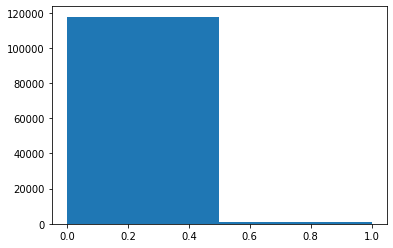

In [11]:
plt.hist(data_features['isFraud'].tolist(),bins=2)

In [57]:
data_features

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,isFraud
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,0.0
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,0.0
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,0.0
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,0.0
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,0.0
...,...,...,...,...,...,...,...,...,...,...,...
118616,2018-01-30T23:52:16Z,103590747A1,d3c036ac,0b1dae,6300,826,NN1,81,50.91,7500,0.0
118617,2018-01-30T23:57:16Z,18903650A1,e0ad403a,e5d3c5,5812,826,TW9,5,71.00,10500,0.0
118618,2018-01-30T23:59:03Z,103582443A1,d3c036ac,0b1dae,6300,826,NN1,81,17.00,8500,0.0
118619,2018-01-31T00:04:44Z,14841868A1,ec212849,1ab20c,4812,826,SL1,1,11.00,7500,0.0


In [55]:
data_features.apply(lambda x : x.isnull().sum())

transactionTime          0
eventId                  0
accountNumber            0
merchantId               0
mcc                      0
merchantCountry          0
merchantZip          23005
posEntryMode             0
transactionAmount        0
availableCash            0
isFraud                  0
dtype: int64